In [1]:
from scipy.spatial.distance import cdist
import commoncode as commoncode
import numpy as np
import matplotlib.pyplot as plt
import SkewGP as SkewGP
import GPy as GPy
from matplotlib import pyplot as plt
from scipy.stats import bernoulli
from scipy.stats import norm
import pymc3 as pm

## 1D example
We generate some data

Text(0, 0.5, 'class')

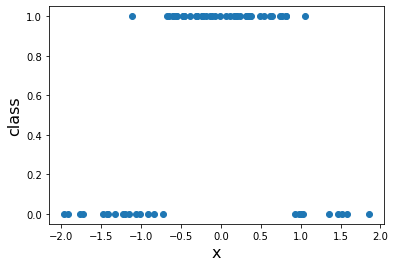

In [2]:
np.random.seed(42)
N=70
X=np.random.randn(N,1)
y=bernoulli.rvs(norm.cdf(np.cos(2.0*X)*3))#binary class

plt.scatter(X,y)
plt.xlabel("x",fontsize=16)
plt.ylabel("class",fontsize=16)

We define the Kernel and an empty skewness function for SkewGP. We are going to use  a zero dimension SkewGP, which is a GP prior and so we do not need Delta.

In [3]:
#define RBF kernel function
def Kernel(X1,X2,params,diag_=False):
    lengthscale=params['lengthscale']['value']
    variance   =params['variance']['value']
    if diag_==False:
        diffs = cdist(np.atleast_2d(X1)/ lengthscale, np.atleast_2d(X2) / lengthscale, metric='sqeuclidean')
    else:
        diffs = np.sum((np.atleast_2d(X1)/ lengthscale-np.atleast_2d(X2)/ lengthscale)*(np.atleast_2d(X1)/ lengthscale-np.atleast_2d(X2)/ lengthscale),axis=1)
    return variance * np.exp(-0.5 * diffs)
   
#define skewness function
def Delta(X,params):
    #empty
    return []

logexp=commoncode.logexp()
latent_dim=0

#Hyperparameters of the kernel
params0={'lengthscale': {'value':np.array([1.0]), 
                    'range':np.vstack([[0.0001, 50.0]]),
                    'transform': logexp},
         'variance': {'value':np.array([1.0]), 
                    'range':np.vstack([[0.001, 100.0]]),
                    'transform': logexp},
         'noise_variance': {'value':np.array([1.0]), #this is not used in classification
                    'range':np.vstack([[1.0, 1.0001]]),
                    'transform': logexp}
      }

Note that we can use any kernel. For instance you can use kernels from GPy.


    def Kernel(X1,X2,params,diag_=False):
        lengthscale=params['lengthscale']['value']
        variance   =params['variance']['value']
        kern = GPy.kern.Matern32(X1.shape[1],lengthscale=lengthscale,variance=variance)
        return kern.K(X1,X2)
       
We now need to define the matrix Z,W for the affine probit likelihood.


In [15]:
W = np.diag(y[:,0]*2-1.0)
Z=np.zeros((W.shape[0],1))

In [16]:
model = SkewGP.SkewGP(X,Kernel, Delta, params0, W=W, Z=Z,  latent_dim =latent_dim, type_y='affine', jitter=1e-6)
#we optimize the hyperparameters
ml=model.optimize(max_iters=1000) 
print("Marginal Likelihood",ml)

Iteration 0  -19.404032560820752
Marginal Likelihood -19.404032560820752


In [6]:
model.params

{'lengthscale': {'value': array([0.3032238]),
  'range': array([[1.e-04, 5.e+01]]),
  'transform': <commoncode.logexp at 0x7fb9871217f0>},
 'variance': {'value': array([14.46220477]),
  'range': array([[1.e-03, 1.e+02]]),
  'transform': <commoncode.logexp at 0x7fb9871217f0>},
 'noise_variance': {'value': array([1.00002243]),
  'range': array([[1.    , 1.0001]]),
  'transform': <commoncode.logexp at 0x7fb9871217f0>}}

Nowe we compute the predictions. The following code calls `lin-ess` sampler.

In [7]:
Xpred=np.linspace(-3,3,200)[:,None]
predictions=model.predict(Xpred,nsamples=5000)

Start Lin-Ess sampler
Progress: |██████████████████████████████████████████████████| 100.0% Complete


 /home/benavoli/anaconda3/envs/myenv/lib/python3.8/site-packages/arviz/stats/stats.py:337: UserWarning:hpd will be deprecated Please replace hdi
 /home/benavoli/anaconda3/envs/myenv/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning:hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


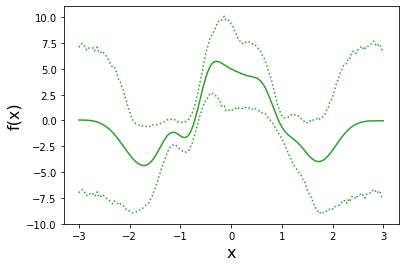

In [8]:
#we compute the credible intervals
credib_int = pm.stats.hpd(predictions.T)
#we plot the latent function mean and credible interval
plt.plot(Xpred[:,0],credib_int[:,1],color='C2', linestyle=':')
plt.plot(Xpred[:,0],credib_int[:,0],color='C2', linestyle=':')
plt.plot(Xpred[:,0],np.mean(predictions,axis=1), label='mean',color='C2')
plt.xlabel("x",fontsize=16)
plt.ylabel("f(x)",fontsize=16);

We can  compute the posterior on the probability of class $1$

 /home/benavoli/anaconda3/envs/myenv/lib/python3.8/site-packages/arviz/stats/stats.py:337: UserWarning:hpd will be deprecated Please replace hdi
 /home/benavoli/anaconda3/envs/myenv/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning:hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
 <ipython-input-12-00b709f5e0fd>:3: MatplotlibDeprecationWarning:Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


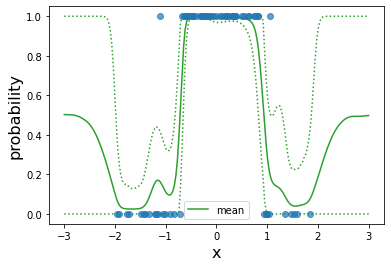

In [12]:

prob_SGp = norm.cdf(predictions)
credib_int = pm.stats.hpd(prob_SGp.T)
plt.scatter(X,y, alpha=0.7, Zorder=1000)
plt.plot(Xpred[:,0],np.mean(prob_SGp,axis=1),color='C2', label='mean')
plt.plot(Xpred[:,0],credib_int[:,1],color='C2', linestyle=':')
plt.plot(Xpred[:,0],credib_int[:,0],color='C2', linestyle=':')
plt.xlabel("x",fontsize=16)
plt.ylabel("probability",fontsize=16)
plt.legend()

In [13]:
indx = np.argmin((Xpred[:,0]-0.25)**2)

Text(0.5, 0, 'f(0.25)')

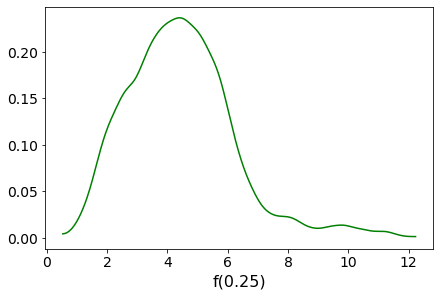

In [14]:
import arviz as az
az.plot_dist(predictions[indx,:],color='g')
plt.xlabel("f(0.25)",fontsize=16)